In [1021]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from torch import optim, nn
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb


import copy
%matplotlib inline

rng = 0

test_values = pd.read_csv("./test-set-values.csv")
train_values = pd.read_csv("./training-set-values.csv")
train_labels = pd.read_csv("./training-set-labels.csv")


In [1022]:
print("columns:")
print(train_values.columns.values)
print()
print(train_values.info())

columns:
['id' 'amount_tsh' 'date_recorded' 'funder' 'gps_height' 'installer'
 'longitude' 'latitude' 'wpt_name' 'num_private' 'basin' 'subvillage'
 'region' 'region_code' 'district_code' 'lga' 'ward' 'population'
 'public_meeting' 'recorded_by' 'scheme_management' 'scheme_name' 'permit'
 'construction_year' 'extraction_type' 'extraction_type_group'
 'extraction_type_class' 'management' 'management_group' 'payment'
 'payment_type' 'water_quality' 'quality_group' 'quantity'
 'quantity_group' 'source' 'source_type' 'source_class' 'waterpoint_type'
 'waterpoint_type_group']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 


In [1023]:
train_values.iloc[:, :20].describe(include='all')

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by
count,59400.000000,59400.000000,59400,55765,59400.000000,55745,59400.000000,5.940000e+04,59400,59400.000000,59400,59029,59400,59400.000000,59400.000000,59400,59400,59400.000000,56066,59400
unique,NaN,NaN,356,1897,NaN,2145,NaN,NaN,37400,NaN,9,19287,21,NaN,NaN,125,2092,NaN,2,1
top,NaN,NaN,2011-03-15,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,Lake Victoria,Madukani,Iringa,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd
freq,NaN,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,10248,508,5294,NaN,NaN,2503,307,NaN,51011,59400
mean,37115.131768,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,NaN,NaN,NaN,15.297003,5.629747,NaN,NaN,179.909983,NaN,NaN
std,21453.128371,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,NaN,NaN,NaN,17.587406,9.633649,NaN,NaN,471.482176,NaN,NaN
min,0.000000,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN
25%,18519.750000,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,NaN,NaN,NaN,5.000000,2.000000,NaN,NaN,0.000000,NaN,NaN
50%,37061.500000,0.000000,NaN,NaN,369.000000,NaN,34.908743,-5.021597e+00,NaN,0.000000,NaN,NaN,NaN,12.000000,3.000000,NaN,NaN,25.000000,NaN,NaN
75%,55656.500000,20.000000,NaN,NaN,1319.250000,NaN,37.178387,-3.326156e+00,NaN,0.000000,NaN,NaN,NaN,17.000000,5.000000,NaN,NaN,215.000000,NaN,NaN


In [1024]:
train_values.iloc[:, 21:].describe(include='all')

,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,31234,56344,59400.000000,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,2696,2,NaN,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,K,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,682,38852,NaN,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625
mean,NaN,NaN,1300.652475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,951.620547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,1986.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2004.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1025]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [1026]:
train_values.drop("num_private",axis=1,inplace=True)

In [1027]:
d = {
    "date_recorded": "string",
    "funder": "string",
    "installer": "string",
    "wpt_name": "string",
    "basin": "string",
    "subvillage": "string",
    "region": "string",
    "lga": "string",
    "ward": "string",
    "public_meeting": "string",
    "recorded_by": "string",
    "scheme_management": "string",
    "scheme_name": "string",
    "permit": "string",
    "extraction_type": "string",
    "extraction_type_group": "string",
    "extraction_type_class": "string",
    "management": "string",
    "management_group": "string",
    "payment": "string",
    "payment_type": "string",
    "water_quality": "string",
    "quality_group": "string",
    "quantity": "string",
    "quantity_group": "string",
    "source": "string",
    "source_type": "string",
    "source_class": "string",
    "waterpoint_type": "string",
    "waterpoint_type_group": "string",
}
train_values= train_values.astype(d)
train_values["date_recorded"] = pd.to_datetime(
    train_values["date_recorded"],
    infer_datetime_format=True
)

train_labels.status_group = train_labels.status_group.astype('string')


print(train_values.date_recorded.describe())
print()
pd.to_datetime(train_values.date_recorded).describe(datetime_is_numeric=True)

count                   59400
unique                    356
top       2011-03-15 00:00:00
freq                      572
first     2002-10-14 00:00:00
last      2013-12-03 00:00:00
Name: date_recorded, dtype: object



/tmp/ipykernel_144335/2943963355.py:42: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(train_values.date_recorded.describe())


count                            59400
mean     2012-03-29 09:11:33.818181888
min                2002-10-14 00:00:00
25%                2011-04-01 00:00:00
50%                2012-10-10 00:00:00
75%                2013-02-09 00:00:00
max                2013-12-03 00:00:00
Name: date_recorded, dtype: object

# Null and Nan checking

In [1028]:
print("any nulls in train_values?")
print(pd.isnull(train_values).any()[lambda x: x == True])
print()
print("any NANs in train_values?")
print(pd.isna(train_values).any()[lambda x:x == True])


any nulls in train_values?
funder               True
installer            True
subvillage           True
public_meeting       True
scheme_management    True
scheme_name          True
permit               True
dtype: bool

any NANs in train_values?
funder               True
installer            True
subvillage           True
public_meeting       True
scheme_management    True
scheme_name          True
permit               True
dtype: bool


In [1029]:
train_values.fillna("Unknown",inplace=True)

PS: The features not shown are false for both cases


### train_values have the same features with both NANs and nulls.

In [1030]:
print("any nulls or NANs in train_labels?")
print(pd.isnull(train_labels).any())
print(pd.isna(train_labels).any())


any nulls or NANs in train_labels?
id              False
status_group    False
dtype: bool
id              False
status_group    False
dtype: bool


# Showing Values:

In [1031]:
train_values.iloc[:, :20].head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,Unknown,GeoData Consultants Ltd,Other
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,Unknown


In [1032]:
train_values.iloc[:, 21:40].head()


,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


# Showing unique values in cetain columns with fewer categories:

There are alot of "0" strings around the features, they will be imputed to be "Unknown" just like the nulls and Nans.

In [1033]:
imputer = SimpleImputer(missing_values="0",fill_value="unknown",strategy='constant')
temp = imputer.fit_transform(train_values)
train_values= pd.DataFrame(temp ,columns=train_values.columns)

In [1034]:
print("Count of Unique dates recorded: "+str(len(train_values.date_recorded.unique())))
print()
print(train_values.date_recorded.value_counts().head(20))

Count of Unique dates recorded: 356

2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
2011-03-18    497
2011-03-19    466
2013-02-04    464
2013-01-29    459
2011-03-04    458
2013-02-14    444
2013-01-24    435
2011-03-05    434
2013-02-15    429
2013-03-15    428
2011-03-11    426
2013-01-30    421
2013-02-16    418
2011-03-23    417
2011-03-09    416
Name: date_recorded, dtype: int64


In [1035]:
print("Count of Unique funders: "+str(len(train_values.funder.unique())))
print()
print(train_values.funder.value_counts().head(20))


Count of Unique funders: 1897

Government Of Tanzania    9084
Unknown                   3639
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
District Council           843
Dhv                        829
Private Individual         826
Dwsp                       811
unknown                    777
Norad                      765
Germany Republi            610
Tcrs                       602
Ministry Of Water          590
Water                      583
Name: funder, dtype: int64


In [1036]:
print("Count of unique installers: "+str(len(train_values.installer.unique())))
train_values.installer.value_counts().head(20)

Count of unique installers: 2144


DWE                   17402
Unknown                3658
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
unknown                 778
TCRS                    707
Central government      622
CES                     610
Community               553
DANID                   552
District Council        551
HESAWA                  539
LGA                     408
World vision            408
WEDECO                  397
TASAF                   396
Name: installer, dtype: int64

In [1037]:
train_values.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [1038]:
train_values.subvillage.value_counts().head(20)

Madukani      508
Shuleni       506
Majengo       502
Kati          373
Unknown       371
Mtakuja       262
Sokoni        232
M             187
Muungano      172
Mbuyuni       164
Mlimani       152
Songambele    147
Msikitini     134
Miembeni      134
1             132
Kibaoni       114
Kanisani      111
I             109
Mapinduzi     109
Mjimwema      108
Name: subvillage, dtype: int64

In [1039]:
train_values.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [1040]:
train_values['region'].unique()

array(['Iringa', 'Mara', 'Manyara', 'Mtwara', 'Kagera', 'Tanga',
       'Shinyanga', 'Tabora', 'Pwani', 'Ruvuma', 'Kilimanjaro', 'Rukwa',
       'Mwanza', 'Kigoma', 'Lindi', 'Dodoma', 'Arusha', 'Mbeya',
       'Singida', 'Morogoro', 'Dar es Salaam'], dtype=object)

In [1041]:
train_values['district_code'].unique()


array([5, 2, 4, 63, 1, 8, 3, 6, 43, 7, 23, 33, 53, 62, 60, 30, 13, 0, 80,
       67], dtype=object)

In [1042]:
train_values['lga'].unique()

array(['Ludewa', 'Serengeti', 'Simanjiro', 'Nanyumbu', 'Karagwe',
       'Mkinga', 'Shinyanga Rural', 'Kahama', 'Tabora Urban', 'Mkuranga',
       'Namtumbo', 'Maswa', 'Siha', 'Meatu', 'Sumbawanga Rural', 'Njombe',
       'Ukerewe', 'Bariadi', 'Same', 'Kigoma Rural', 'Moshi Rural',
       'Lindi Rural', 'Rombo', 'Chamwino', 'Bagamoyo', 'Mafia',
       'Arusha Rural', 'Kyela', 'Kondoa', 'Kilolo', 'Kibondo', 'Makete',
       'Singida Rural', 'Masasi', 'Rungwe', 'Moshi Urban', 'Geita',
       'Mbulu', 'Bukoba Rural', 'Muheza', 'Lushoto', 'Meru', 'Iramba',
       'Kilombero', 'Mbarali', 'Kasulu', 'Bukoba Urban', 'Korogwe',
       'Bukombe', 'Morogoro Rural', 'Kishapu', 'Musoma Rural',
       'Sengerema', 'Iringa Rural', 'Muleba', 'Dodoma Urban', 'Ruangwa',
       'Hanang', 'Misenyi', 'Missungwi', 'Songea Rural', 'Tanga',
       'Tunduru', 'Hai', 'Mwanga', 'Chato', 'Biharamulo', 'Ileje',
       'Mpwapwa', 'Mvomero', 'Bunda', 'Kiteto', 'Longido', 'Urambo',
       'Mbozi', 'Sikonge', 'Ilala',

In [1043]:
train_values.district_code.unique()

array([5, 2, 4, 63, 1, 8, 3, 6, 43, 7, 23, 33, 53, 62, 60, 30, 13, 0, 80,
       67], dtype=object)

In [1044]:
train_values.lga.unique()

array(['Ludewa', 'Serengeti', 'Simanjiro', 'Nanyumbu', 'Karagwe',
       'Mkinga', 'Shinyanga Rural', 'Kahama', 'Tabora Urban', 'Mkuranga',
       'Namtumbo', 'Maswa', 'Siha', 'Meatu', 'Sumbawanga Rural', 'Njombe',
       'Ukerewe', 'Bariadi', 'Same', 'Kigoma Rural', 'Moshi Rural',
       'Lindi Rural', 'Rombo', 'Chamwino', 'Bagamoyo', 'Mafia',
       'Arusha Rural', 'Kyela', 'Kondoa', 'Kilolo', 'Kibondo', 'Makete',
       'Singida Rural', 'Masasi', 'Rungwe', 'Moshi Urban', 'Geita',
       'Mbulu', 'Bukoba Rural', 'Muheza', 'Lushoto', 'Meru', 'Iramba',
       'Kilombero', 'Mbarali', 'Kasulu', 'Bukoba Urban', 'Korogwe',
       'Bukombe', 'Morogoro Rural', 'Kishapu', 'Musoma Rural',
       'Sengerema', 'Iringa Rural', 'Muleba', 'Dodoma Urban', 'Ruangwa',
       'Hanang', 'Misenyi', 'Missungwi', 'Songea Rural', 'Tanga',
       'Tunduru', 'Hai', 'Mwanga', 'Chato', 'Biharamulo', 'Ileje',
       'Mpwapwa', 'Mvomero', 'Bunda', 'Kiteto', 'Longido', 'Urambo',
       'Mbozi', 'Sikonge', 'Ilala',

In [1045]:
train_values.ward.value_counts().head(20)

Igosi            307
Imalinyi         252
Siha Kati        232
Mdandu           231
Nduruma          217
Mishamo          203
Kitunda          203
Msindo           201
Chalinze         196
Maji ya Chai     190
Usuka            187
Ngarenanyuki     172
Chanika          171
Vikindu          162
Mtwango          153
Matola           145
Zinga/Ikerege    141
Wanging'ombe     139
Maramba          139
Itete            137
Name: ward, dtype: int64

Column with same data: GeoData Consultants Ltd.  
Not useful.

In [1046]:
print(train_values.recorded_by.value_counts())
train_values.drop('recorded_by',inplace=True,axis=1)
train_values.drop('wpt_name',inplace=True,axis=1)


GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64


In [1047]:
train_values[['scheme_management']].apply(pd.Series.value_counts)

,scheme_management
VWC,36793
WUG,5206
Unknown,3877
Water authority,3153
WUA,2883
Water Board,2748
Parastatal,1680
Private operator,1063
Company,1061
Other,766


In [1048]:
train_values.scheme_name.value_counts().head(20)

Unknown                                  28166
K                                          682
None                                       644
Borehole                                   546
Chalinze wate                              405
M                                          400
DANIDA                                     379
Government                                 320
Ngana water supplied scheme                270
wanging'ombe water supply s                261
wanging'ombe supply scheme                 234
I                                          229
Bagamoyo wate                              229
Uroki-Bomang'ombe water sup                209
N                                          204
Kirua kahe gravity water supply trust      193
Machumba estate pipe line                  185
Makwale water supplied sche                166
Kijiji                                     161
S                                          154
Name: scheme_name, dtype: int64

In [1049]:
train_values.permit.value_counts(())

True       38852
False      17492
Unknown     3056
Name: permit, dtype: int64

In [1050]:
train_values.construction_year.unique()

array([1999, 2010, 2009, 1986, 0, 2011, 1987, 1991, 1978, 1992, 2008,
       1974, 2000, 2002, 2004, 1972, 2003, 1980, 2007, 1973, 1985, 1970,
       1995, 2006, 1962, 2005, 1997, 2012, 1996, 1977, 1983, 1984, 1990,
       1982, 1976, 1988, 1989, 1975, 1960, 1961, 1998, 1963, 1971, 1994,
       1968, 1993, 2001, 1979, 1967, 2013, 1969, 1981, 1964, 1966, 1965],
      dtype=object)

In [1051]:
train_values[['extraction_type','extraction_type_group','extraction_type_class']].apply(pd.Series.value_counts)

,extraction_type,extraction_type_group,extraction_type_class
afridev,1770.0,1770.0,NaN
cemo,90.0,NaN,NaN
climax,32.0,NaN,NaN
gravity,26780.0,26780.0,26780.0
handpump,NaN,NaN,16456.0
india mark ii,2400.0,2400.0,NaN
india mark iii,98.0,98.0,NaN
ksb,1415.0,NaN,NaN
mono,2865.0,2865.0,NaN
motorpump,NaN,NaN,2987.0


In [1052]:
print(train_values[(train_values.extraction_type == 'afridev') & (train_values.extraction_type_group== 'afridev')].shape[0])
print(train_values[(train_values.extraction_type == 'gravity') & (train_values.extraction_type_group== 'gravity') & (train_values.extraction_type_class== 'gravity')].shape[0])
print(train_values[(train_values.extraction_type == 'india mark ii') & (train_values.extraction_type_group== 'india mark ii')].shape[0])
print(train_values[(train_values.extraction_type == 'india mark iii') & (train_values.extraction_type_group== 'india mark iii')].shape[0])
print(train_values[(train_values.extraction_type == 'mono') & (train_values.extraction_type_group== 'mono')].shape[0])
print(train_values[(train_values.extraction_type == 'nira/tanira') & (train_values.extraction_type_group== 'nira/tanira')].shape[0])
print(train_values[(train_values.extraction_type == 'other') & (train_values.extraction_type_group== 'other') & (train_values.extraction_type_class== 'other')].shape[0])
print(train_values[(train_values.extraction_type_group== 'submersible') & (train_values.extraction_type_class== 'submersible')].shape[0])
print(train_values[(train_values.extraction_type == 'swn 80') & (train_values.extraction_type_group== 'swn 80')].shape[0])
print(train_values[(train_values.extraction_type == 'windmill') & (train_values.extraction_type_group== 'wind-powered') & (train_values.extraction_type_class== 'wind-powered')].shape[0])

1770
26780
2400
98
2865
8154
6430
6179
3670
117


The numbers from the previous cell coinsides with the previous previous cell.

Handpumps and other handpumps:

In [1053]:
train_values[train_values.extraction_type_class == "handpump"][['extraction_type','extraction_type_group','extraction_type_class']].value_counts()

extraction_type            extraction_type_group  extraction_type_class
nira/tanira                nira/tanira            handpump                 8154
swn 80                     swn 80                 handpump                 3670
india mark ii              india mark ii          handpump                 2400
afridev                    afridev                handpump                 1770
other - swn 81             other handpump         handpump                  229
india mark iii             india mark iii         handpump                   98
other - play pump          other handpump         handpump                   85
walimi                     other handpump         handpump                   48
other - mkulima/shinyanga  other handpump         handpump                    2
dtype: int64

In [1054]:
train_values[train_values.extraction_type_group == "other handpump"][['extraction_type','extraction_type_group','extraction_type_class']].value_counts()

extraction_type            extraction_type_group  extraction_type_class
other - swn 81             other handpump         handpump                 229
other - play pump          other handpump         handpump                  85
walimi                     other handpump         handpump                  48
other - mkulima/shinyanga  other handpump         handpump                   2
dtype: int64

Motorpumps and other motorpumps:

In [1055]:
train_values[train_values.extraction_type_class == "motorpump"][['extraction_type','extraction_type_group','extraction_type_class']].value_counts()

extraction_type  extraction_type_group  extraction_type_class
mono             mono                   motorpump                2865
cemo             other motorpump        motorpump                  90
climax           other motorpump        motorpump                  32
dtype: int64

In [1056]:
train_values[train_values.extraction_type_group == "other motorpump"][['extraction_type','extraction_type_group','extraction_type_class']].value_counts()

extraction_type  extraction_type_group  extraction_type_class
cemo             other motorpump        motorpump                90
climax           other motorpump        motorpump                32
dtype: int64

'extraction_type_group' seems to be redundant so it is dropped.  
  
### The ceveat is that I did not check as throughly as some of the other columns as I have done in the next few cells.

In [1057]:
train_values.drop('extraction_type_group', inplace=True, axis=1)

In [1058]:
print(train_values[['management','management_group']].apply(pd.Series.value_counts))
train_values[['management','management_group']].sample(20)

                  management  management_group
commercial               NaN            3638.0
company                685.0               NaN
other                  844.0             943.0
other - school          99.0               NaN
parastatal            1768.0            1768.0
private operator      1971.0               NaN
trust                   78.0               NaN
unknown                561.0             561.0
user-group               NaN           52490.0
vwc                  40507.0               NaN
water authority        904.0               NaN
water board           2933.0               NaN
wua                   2535.0               NaN
wug                   6515.0               NaN


,management,management_group
1121,vwc,user-group
28785,wug,user-group
4233,vwc,user-group
968,vwc,user-group
401,water board,user-group
52890,vwc,user-group
22939,vwc,user-group
964,vwc,user-group
2685,vwc,user-group
1440,wug,user-group


In [1059]:
train_values[['payment','payment_type']].apply(pd.Series.value_counts)

,payment,payment_type
annually,NaN,3642.0
monthly,NaN,8300.0
never pay,25348.0,25348.0
on failure,NaN,3914.0
other,1054.0,1054.0
pay annually,3642.0,NaN
pay monthly,8300.0,NaN
pay per bucket,8985.0,NaN
pay when scheme fails,3914.0,NaN
per bucket,NaN,8985.0


In [1060]:
print("Row counts that has both mentioned strings in their respective columns:")
print(train_values[(train_values.payment == 'pay monthly') & (train_values.payment_type == 'monthly')].shape[0])
print(train_values[(train_values.payment == 'pay annually') & (train_values.payment_type == 'annually')].shape[0])
print(train_values[(train_values.payment == 'pay per bucket') & (train_values.payment_type == 'per bucket')].shape[0])
print(train_values[(train_values.payment == 'pay when scheme fails') & (train_values.payment_type == 'on failure')].shape[0])

Row counts that has both mentioned strings in their respective columns:
8300
3642
8985
3914


From the cell above certain string pairs has the same meaning and row count coninsiding with both strings' value_counts from the previous cells.  
Eg: both 'pay monthly' and 'monthly' has the same counts.

There other strings with same counts in both 'payment' and 'payment_type'.

So one of the columns is redundant and seeing 'payment' column and the unique strings, it make less sense than 'payment types' and their unique strings. 

So I will drop 'payment'

In [1061]:
train_values.drop('payment',inplace=True,axis=1)

In [1062]:
print(train_values[['water_quality','quality_group']].apply(pd.Series.value_counts))

                    water_quality  quality_group
colored                       NaN          490.0
coloured                    490.0            NaN
fluoride                    200.0          217.0
fluoride abandoned           17.0            NaN
good                          NaN        50818.0
milky                       804.0          804.0
salty                      4856.0         5195.0
salty abandoned             339.0            NaN
soft                      50818.0            NaN
unknown                    1876.0         1876.0


In [1063]:
print("Row counts that has the mentioned strings in their respective columns:")
print(train_values[(train_values.water_quality == 'coloured') & (train_values.quality_group == 'colored')].shape[0])
print(train_values[((train_values.water_quality == 'fluoride') | (train_values.water_quality == 'fluoride abandoned')) & (train_values.quality_group == 'fluoride')].shape[0])
print(train_values[(train_values.water_quality == 'soft') & (train_values.quality_group == 'good')].shape[0])
print(train_values[((train_values.water_quality == 'salty') | (train_values.water_quality == 'salty abandoned')) & (train_values.quality_group == 'salty')].shape[0])

Row counts that has the mentioned strings in their respective columns:
490
217
50818
5195


For 'water_quality' and 'quality_group' similar deduction can be made here just like 'payment' and 'payment_type' case.

'water_quality' gives more description than 'quality_group'
So I will drop 'quality_group'

In [1064]:
train_values.drop('quality_group',inplace=True,axis=1)

In [1065]:
print(train_values[['quantity','quantity_group']].apply(pd.Series.value_counts))
train_values[train_values.quantity == train_values.quantity_group].loc[:,'quantity'].count()

              quantity  quantity_group
enough           33186           33186
insufficient     15129           15129
dry               6246            6246
seasonal          4050            4050
unknown            789             789


59400

In [1066]:
print("Row counts that has the mentioned strings in their respective columns:")
print(train_values[(train_values.quantity == 'enough') & (train_values.quantity_group == 'enough')].shape[0])
print(train_values[(train_values.quantity == 'insufficient') & (train_values.quantity_group == 'insufficient')].shape[0])
print(train_values[(train_values.quantity == 'dry') & (train_values.quantity_group == 'dry')].shape[0])
print(train_values[(train_values.quantity == 'seasonal') & (train_values.quantity_group == 'seasonal')].shape[0])
print(train_values[(train_values.quantity == 'unknown') & (train_values.quantity_group == 'unknown')].shape[0])


Row counts that has the mentioned strings in their respective columns:
33186
15129
6246
4050
789


For 'quantity' and 'quantity_group' similar deduction can be made here just like 'payment' and 'payment_type' case.

In [1067]:
train_values.drop('quantity_group',inplace=True,axis=1)

In [1068]:
train_values[['source','source_type','source_class']].apply(pd.Series.value_counts)

,source,source_type,source_class
borehole,NaN,11949.0,NaN
dam,656.0,656.0,NaN
groundwater,NaN,NaN,45794.0
hand dtw,874.0,NaN,NaN
lake,765.0,NaN,NaN
machine dbh,11075.0,NaN,NaN
other,212.0,278.0,NaN
rainwater harvesting,2295.0,2295.0,NaN
river,9612.0,NaN,NaN
river/lake,NaN,10377.0,NaN


In [1069]:
train_values[['waterpoint_type','waterpoint_type_group']].apply(pd.Series.value_counts)

,waterpoint_type,waterpoint_type_group
cattle trough,116,116.0
communal standpipe,28522,34625.0
communal standpipe multiple,6103,NaN
dam,7,7.0
hand pump,17488,17488.0
improved spring,784,784.0
other,6380,6380.0


In [1070]:
print(train_values[(train_values.waterpoint_type == 'cattle trough') & (train_values.waterpoint_type_group == 'cattle trough')].shape[0])
print(train_values[((train_values.waterpoint_type == 'communal standpipe') | (train_values.waterpoint_type == 'communal standpipe multiple')) & (train_values.waterpoint_type_group == 'communal standpipe')].shape[0])
print(train_values[(train_values.waterpoint_type == 'dam') & (train_values.waterpoint_type_group == 'dam')].shape[0])
print(train_values[(train_values.waterpoint_type == 'hand pump') & (train_values.waterpoint_type_group == 'hand pump')].shape[0])
print(train_values[(train_values.waterpoint_type == 'improved spring') & (train_values.waterpoint_type_group == 'improved spring')].shape[0])
print(train_values[(train_values.waterpoint_type == 'other') & (train_values.waterpoint_type_group == 'other')].shape[0])

116
34625
7
17488
784
6380


Columns are compared similar to previous cases above.  
I think it is safe to drop waterpoint_type_group while keeps most of the information in place.

In [1071]:
train_values.drop('waterpoint_type_group',inplace=True,axis=1)

In [1072]:
print(train_values.columns)
print("New columns count: "+ str(len(train_values.columns)))

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_class',
       'management', 'management_group', 'payment_type', 'water_quality',
       'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type'],
      dtype='object')
New columns count: 32


In [1073]:
numerical_variables = [
    "amount_tsh",
    "gps_height",
    "longitude",
    "latitude",
    "region_code",
    "district_code",
    "population",
    "construction_year",
]


# Checking correlations between numerical features

/home/ryan/anaconda3/envs/pump-it-up/lib/python3.10/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/ryan/anaconda3/envs/pump-it-up/lib/python3.10/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<AxesSubplot:>

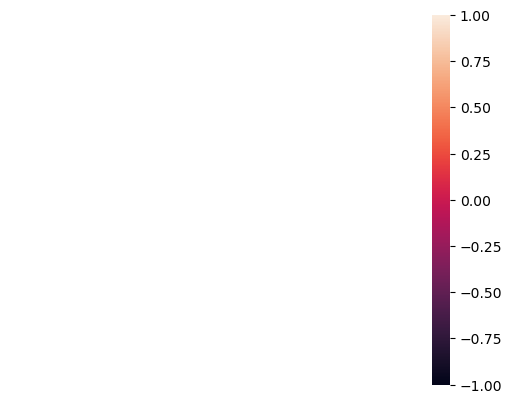

In [1074]:
train = train_values.merge(train_labels, on="id")

# sns.pairplot(train.sample(1000),kind="scatter")
# commented out the previous line because running all with this line is very slow

sns.heatmap(data=train.corr(), vmin=-1, vmax=1, annot=True)


There is not much useful correlations inbetween the numerical features

Including population and amount of tsh

## Question: Does construction year have some correlation with pump status?


Earliest construction year excluding year 0:

In [1075]:
train.construction_year[lambda x: x > 0].sort_values().head(1)


4562    1960
Name: construction_year, dtype: object

In [1076]:
g = train.groupby(by=["construction_year", "status_group"]
                  ).size().reset_index()

g.head()

# plt.plot(g)
# fig,ax = plt.subplot(1,3,1,sharex=True,sharey=True)

# ax.hist(g,range=(1960,g.max()))
# # ax.set()
# plt.show()

# plt.plot(g)


,construction_year,status_group,0
0,0,functional,10555
1,0,functional needs repair,1789
2,0,non functional,8365
3,1960,functional,24
4,1960,functional needs repair,6
